# ETM595 Project

## Table of Contents
1. Introduction
    * 5 tane boşluk koydum alt alta kopyalayın ben hallederim gerisini
2. example portfolios
    * 2.1 Example Portfolio Weigths
    * 2.2 Example Portfolio Statistics
	* 2.3 Example Portfolio Probabilities
3. Markowitz Model Application
	* 3.1 Markowitz model
    * 3.2 Standard Deviation - Return Diagram
        * 3.2.1 Simulation Metholodogy
        * 3.2.2 Efficient Frontier, Shorting Not Allowed
        * 3.2.3 Efficient Frontier, Shorting Allowed
	* 3.3 Solutions
        * 3.3.1 Shorting Not Allowed, Quadratic Solution
        * 3.3.2 Shorting Allowed, Algebraic Solution
4. One-fund theorem
	* 4.1 Algebraic Model
	* 4.2 Expected Return
	* 4.3 Probability

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize
import scipy.stats as st
import numpy as np, numpy.random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:
def getStockData(stockKey, dataKey):
    #Data Keys : Date, Open, High, Low, Close, Volume

    #stockKey = "AAPL"
    periodStart = "08/07/2021"
    periodEnd = "12/10/2021"


    url = ("https://www.marketwatch.com/investing/stock/{}/downloaddatapartial?startdate={}00:00:00"+\
    "&enddate={}00:00:00"+\
    "&daterange=m6"+\
    "&frequency=p1d"+\
    "&csvdownload=true"+\
    "&downloadpartial=false&newdates=false").format(
        stockKey,
        periodStart,
        periodEnd
        )

    #access whole data
    #stockData = pd.read_csv( url )

    return pd.read_csv( url )[dataKey]



In [3]:
def objectToInt( target ):
    #decimal part
    if str.find(target,".") > 0:
         dec = str.split(target,".")[1]
    else:
        dec = ""
    #main part
    main = ""
    for i in str.split( str.split(target,".")[0], "," ):
        main += i
    
    return int(main+dec)/10**len(dec)
    

In [4]:
stockList = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "FB",
    "TSLA", "NVDA", "ADBE", "NFLX", "CRM",
    "CSCO", "QCOM", "INTC", "VZ", "T"
]


errorFlag = 0
closeData = pd.DataFrame()
for stock in stockList:

    #gets the date
    try:
        closeData["Date"]
    except:
        closeData["Date"] = getStockData(stockList[0], "Date")
    
    #gets the stock close value
    try:
        temp = getStockData(stock, "Close")

        #Some data are not of number format
        if temp.dtype == "O":
            closeData[stock] = temp.apply( objectToInt )
        else:
            closeData[stock] = temp

    except:
        errorFlag = 1
    
    if errorFlag == 1:
        print("Error at extracting stock,",stock)
        break
    
if errorFlag == 0:
    print("All data extracted succesfully")

#Saves to desktop
#closeData.to_excel( os.path.expanduser("~/Desktop/") + "stockClose.xlsx" )
closeData.dtypes

All data extracted succesfully


Date      object
AAPL     float64
MSFT     float64
AMZN     float64
GOOGL    float64
FB       float64
TSLA     float64
NVDA     float64
ADBE     float64
NFLX     float64
CRM      float64
CSCO     float64
QCOM     float64
INTC     float64
VZ       float64
T        float64
dtype: object

In [5]:
closeData.head()

,Date,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
0,12/10/2021,179.45,342.54,3444.24,2960.03,329.75,1017.03,301.98,654.45,611.66,266.03,59.25,183.88,50.59,50.19,22.84
1,12/09/2021,174.56,333.10,3483.42,2952.77,329.82,1003.80,304.90,632.57,611.00,264.32,57.55,182.26,50.48,50.16,22.94
2,12/08/2021,175.08,334.97,3523.16,2963.73,330.56,1068.96,318.26,653.10,628.08,266.31,57.02,182.63,51.75,50.49,23.17
3,12/07/2021,171.18,334.92,3523.29,2945.39,322.81,1051.75,324.27,649.96,625.58,266.99,58.08,183.72,52.57,50.79,23.08
4,12/06/2021,165.32,326.19,3427.37,2863.10,317.87,1009.01,300.37,622.04,612.69,258.75,56.96,175.45,50.99,51.07,23.28


In [6]:
changeData = pd.DataFrame()
for col in closeData.columns.values:
    if col == "Date":
        changeData[col] = closeData.iloc[ :closeData.shape[0]-1, np.where(closeData.columns.values == [col])[0][0] ]
    else:
        changeList = []
        for row in range(closeData.shape[0]-1):
            #change value at t represents value(t) - value(t-1)
            changeList.append( (closeData.loc[row,col] - closeData.loc[row+1,col])/closeData.loc[row+1,col] )
        changeData[col] = changeList

        


changeData.head()
changeData.to_excel( os.path.expanduser("~/Desktop/") + "changeData.xlsx" )

In [7]:
#shrinking data to 90 points
closeData = closeData.iloc[:90,:]
changeData = changeData.iloc[:90,:]
closeData.index.rename("Period", inplace=True)
changeData.index.rename("Period", inplace=True)

### 1.5 Covariances of the assests

In [8]:
covariance_matrix= changeData.cov()
covariance_matrix

,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
AAPL,0.000189,9.452891e-05,0.000109,0.000093,0.000095,0.000095,0.000159,0.000119,0.000051,0.000052,0.000045,0.000099,0.000063,-0.000007,2.060449e-06
MSFT,0.000095,1.570478e-04,0.000085,0.000138,0.000098,0.000077,0.000205,0.000157,0.000083,0.000098,0.000065,0.000103,0.000073,0.000003,-8.385666e-07
AMZN,0.000109,8.477681e-05,0.000200,0.000125,0.000114,0.000047,0.000254,0.000127,0.000067,0.000108,0.000007,0.000164,0.000092,-0.000005,4.848624e-06
GOOGL,0.000093,1.376593e-04,0.000125,0.000192,0.000124,0.000043,0.000213,0.000133,0.000063,0.000108,0.000060,0.000121,0.000116,0.000008,1.263322e-05
FB,0.000095,9.763278e-05,0.000114,0.000124,0.000323,0.000136,0.000177,0.000169,0.000105,0.000153,0.000042,0.000142,0.000163,0.000009,3.853273e-05
TSLA,0.000095,7.705742e-05,0.000047,0.000043,0.000136,0.000974,0.000250,0.000168,0.000085,0.000159,-0.000023,0.000122,0.000097,-0.000030,2.404308e-05
NVDA,0.000159,2.052804e-04,0.000254,0.000213,0.000177,0.000250,0.000875,0.000340,0.000145,0.000278,0.000038,0.000411,0.000137,-0.000023,-3.337166e-05
ADBE,0.000119,1.570928e-04,0.000127,0.000133,0.000169,0.000168,0.000340,0.000348,0.000138,0.000184,0.000063,0.000176,0.000082,-0.000013,-1.974114e-05
NFLX,0.000051,8.343183e-05,0.000067,0.000063,0.000105,0.000085,0.000145,0.000138,0.000291,0.000130,0.000018,0.000014,0.000041,0.000003,1.282269e-05
CRM,0.000052,9.808506e-05,0.000108,0.000108,0.000153,0.000159,0.000278,0.000184,0.000130,0.000423,0.000064,0.000168,0.000068,0.000019,4.293428e-05


### 1.6 Conclusion

In conclusion, mean and variance values are used to analyze the assets that have the best potential in terms of profitability and have the least fluctuations in value. And the value of covariance is also used to find the correlation between the assets in the same market. Positive value of covariance reflects the move in the same direction and the negative value of variance reflects the opposite one. For a robust and diversified, low risk portfolio strategy, positive and negative covariances should be picked. However, out assets of choice do not possess negative covariances therefore assets lie near extreme covariance values should be grouped with the ones near zero. In opposition, sectoral combinations with extreme covariances can be employed as portfolio concentration strategy preferably with market insights.

To sum up, it’s possible to see from the table below and the shared excel that we found covariance results from Data Analysis tool. And the above explanations and observations has been written according to the given mean, variance and covariance results.


In [9]:
data_statistics = changeData.describe()
data_statistics

,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.002316,0.002064,0.000391,0.001107,-0.000780,0.004469,0.004860,0.000674,0.002006,0.001167,0.000772,0.002631,-0.000549,-0.001060,-0.002137
std,0.013744,0.012532,0.014129,0.013844,0.017969,0.031205,0.029588,0.018650,0.017063,0.020569,0.012972,0.022078,0.017359,0.007926,0.011383
min,-0.033102,-0.036204,-0.030842,-0.037158,-0.050515,-0.119903,-0.048693,-0.082381,-0.037592,-0.117420,-0.055144,-0.041622,-0.116786,-0.026907,-0.044370
25%,-0.005546,-0.005009,-0.007115,-0.005516,-0.010563,-0.006623,-0.012851,-0.006708,-0.008187,-0.007394,-0.005218,-0.007131,-0.007442,-0.006256,-0.009082
50%,0.002221,0.000817,-0.000289,0.001983,0.000722,0.005021,0.001377,0.001673,0.002669,0.000838,0.000513,-0.001454,0.000092,-0.001005,-0.002371
75%,0.009620,0.009936,0.010053,0.008697,0.011294,0.018694,0.019809,0.011065,0.011157,0.011020,0.007870,0.008659,0.008793,0.003487,0.004028
max,0.035446,0.042114,0.041437,0.049595,0.040123,0.126616,0.120423,0.044885,0.052142,0.072115,0.038441,0.127311,0.035330,0.024069,0.036887


## 2. Example Portfolios

### 2.1 Portfolio Weigths

2.1 Example Portfolio Weigths

In [10]:
weigths_mp = []
weigths_ivp = []
for i in data_statistics.columns.values:
    
    #Weigths of mean proportional portfolio
    weigths_mp.append(data_statistics.loc["mean",i] / sum(data_statistics.loc["mean",:].values))
    
    #Weigths of inverse variance proportional portfolio
    weigths_ivp.append( (1/data_statistics.loc["std",i])/sum(1/data_statistics.loc["std",:].values) )
    
    
example_portfolios = pd.DataFrame({
    "Mean":list( data_statistics.loc["mean",:].values ),
    "Variance": list( data_statistics.loc["std",:].values**2 ),
    "Weigths, Mean":weigths_mp,
    "Weigths, Inverse Variance":weigths_ivp
}).T

for i in range (len(example_portfolios.columns.values)):
    example_portfolios.rename( columns={ example_portfolios.columns.values[i] : data_statistics.columns.values[i] },
                              inplace=True)
example_portfolios


,AAPL,MSFT,AMZN,GOOGL,FB,TSLA,NVDA,ADBE,NFLX,CRM,CSCO,QCOM,INTC,VZ,T
Mean,0.002316,0.002064,0.000391,0.001107,-0.000780,0.004469,0.004860,0.000674,0.002006,0.001167,0.000772,0.002631,-0.000549,-0.001060,-0.002137
Variance,0.000189,0.000157,0.000200,0.000192,0.000323,0.000974,0.000875,0.000348,0.000291,0.000423,0.000168,0.000487,0.000301,0.000063,0.000130
"Weigths, Mean",0.129153,0.115111,0.021821,0.061714,-0.043521,0.249235,0.271052,0.037574,0.111862,0.065106,0.043065,0.146712,-0.030612,-0.059097,-0.119175
"Weigths, Inverse Variance",0.074864,0.082103,0.072822,0.074322,0.057258,0.032973,0.034775,0.055170,0.060301,0.050021,0.079316,0.046603,0.059273,0.129811,0.090387


### 2.2 Example Portfolio Statistics
$$ \frac{1}{2} \sum_{i,j=1}^{n}w_{i}w_{j}σ_{ij} $$ 
$$ \sum_{i=1}^{n}w_{i}ṝ_{i} = ṝ $$

In [11]:
# mean proportional mp, inverse variance proportional ivp
mp_variance = 0
ivp_variance = 0
for i in covariance_matrix.columns.values:
    for ii in covariance_matrix.columns.values:
        mp_variance = mp_variance + covariance_matrix.loc[i,ii]*example_portfolios.loc["Weigths, Mean",i]*example_portfolios.loc["Weigths, Mean",ii]
        ivp_variance = ivp_variance + covariance_matrix.loc[i,ii]*example_portfolios.loc["Weigths, Inverse Variance",i]*example_portfolios.loc["Weigths, Inverse Variance",ii]
print("mp variance: ", mp_variance)
print("ivp variance: ", ivp_variance)

mp_daily_return = 0
ivp_daily_return = 0 
for i in covariance_matrix.columns.values:
    mp_daily_return = mp_daily_return + example_portfolios.loc["Weigths, Mean",i]*example_portfolios.loc["Mean",i]
    ivp_daily_return = ivp_daily_return + example_portfolios.loc["Weigths, Inverse Variance",i]*example_portfolios.loc["Mean",i]
print("mp weekly return:  %", 100*5*mp_daily_return)
print("ivp weekly return:  %", 100*5*ivp_daily_return)


mp variance:  0.00033421025785638326
ivp variance:  7.839291244506904e-05
mp weekly return:  % 2.0787913835143095
ivp weekly return:  % 0.3811792711027852


### 2.3 Example Portfolio Probabilities


$$ z = \frac{x-µ}{σ}$$


In [12]:
weekly_inflation = (0.062/52)
print("Weekly inflation: %", 100*weekly_inflation)

mp_zScore = (weekly_inflation-5*mp_daily_return)/mp_variance
ivp_zScore = (weekly_inflation-5*ivp_daily_return)/ivp_variance
print("mp z-score: ", mp_zScore)
print("ivp z-score: ", ivp_zScore)


print("mp portfolio will outperform inflation with p-value: ",1- st.norm.cdf( mp_zScore ))
print("ivp portfolio will outperform inflation with p-value: ",1- st.norm.cdf( ivp_zScore ))

Weekly inflation: % 0.11923076923076924
mp z-score:  -58.632569414598926
ivp z-score:  -33.41481949092871
mp portfolio will outperform inflation with p-value:  1.0
ivp portfolio will outperform inflation with p-value:  1.0


## 3. Markowitz Model Application

### 3.1 Markowitz Model

$$ \frac{1}{2} \sum_{i,j=1}^{n}w_{i}w_{j}σ_{ij} $$ 

$$ \sum_{i=1}^{n}w_{i}ṝ_{i} = ṝ $$
 

$$ \sum_{i=1}^{n}w_{i} = 1 $$

In [13]:
initial_weigths = list(example_portfolios.loc["Weigths, Mean",:].values)
def objective_ns(initial_weigths):
    var = 0
    for i in range (len(example_portfolios.loc["Weigths, Mean",:].values)):
        for ii in range (len(example_portfolios.loc["Weigths, Mean",:].values)):
            var = var + covariance_matrix.iloc[i,ii]*initial_weigths[i]*initial_weigths[ii]
    return var

def constraint1_ns(initial_weigths):
    mean_returns = example_portfolios.iloc[0,:].values
    daily_return = 0
    for i in range( len(initial_weigths) ):
        daily_return = daily_return + initial_weigths[i]*mean_returns[i]
    return daily_return
    

def constraint2_ns(initial_weigths):
    return (1-np.sum(initial_weigths))



## 3.2 Standard Deviation - Return Diagram

### 3.2.1 Simulation Metholodogy

In order to obtain Standard deviation - Return diagram, simulation is performed. Simulation is applied for return and variance functions. Equations are simulated by generating random feasible inputs and passing through the functions. Inputs used for "non shorting model" and "shorting model" are between 0&1 and -1&+1, respectively. The feasible region is obtained by adding all outputs to the graph. It is recommended for average computers to operate below 10K iterations.


In [14]:
def chartData(returnFunction,
            varianceFunction,
            shape,
            isShortingAllowed, #1 for yes, 0 for no
            iteration):
    
    X=[] #std
    Y=[] #return
    for i in range (iteration):
        
        #random feasible weigths
        if isShortingAllowed == 0:
            rand = np.random.rand(shape,1)
            rand = list( rand/np.sum(rand) )
        elif isShortingAllowed == 1:
            rand = 99
            #soluitons which possess w's greater than 1 are eliminated
            while np.max(rand) > 1:
                rand = np.random.uniform(-1, 1, (shape,1))
                rand = list(rand/np.sum(rand))
        
        X.append( np.sqrt(varianceFunction( rand )) )
        Y.append( returnFunction( rand ) )
        
        
    #plots the simulated data points in a relatively visible size    
    plt.figure(figsize = (18,10))
    plt.scatter( X, Y,
                c = (np.array(Y)*(1/np.array(X))),
                alpha=0.5,
                marker="o" )
    plt.xlim( min(X)-1.5*np.std(X), max(X)+1.5*np.std(X) )
    plt.ylim( min(Y)-1.5*np.std(Y), max(Y)+1.5*np.std(Y) )
    plt.title("Portfolio")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Expected Return")
    plt.show()
        
    #can also return simulation outputs
    #return X,Y

### 3.2.2 Efficient Frontier, Shorting Not Allowed

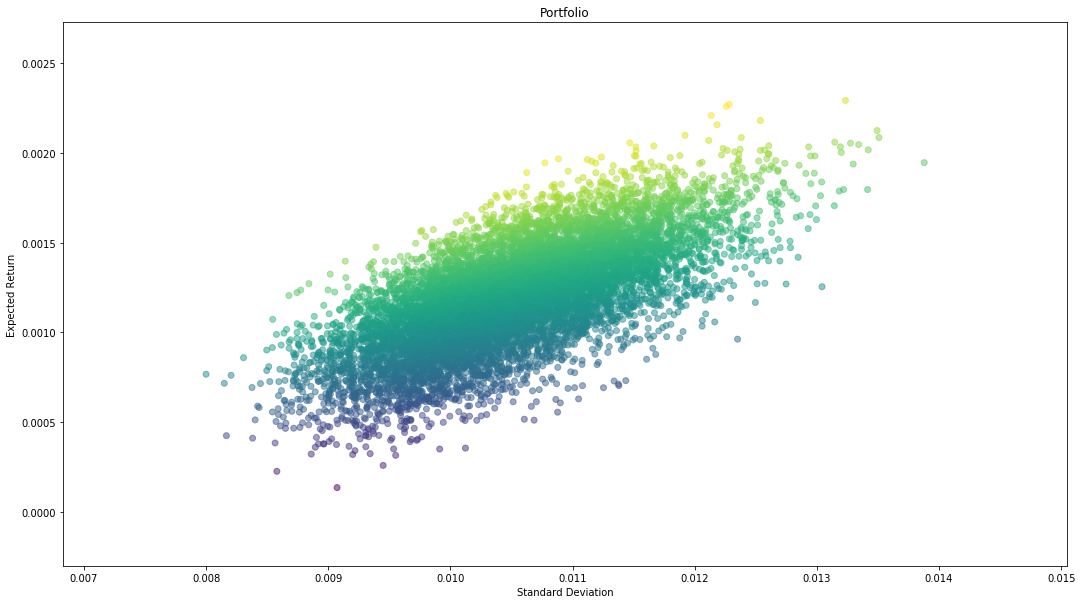

In [15]:
chartData(constraint1_ns,
            objective_ns,
            15,
            0,
            10000)

### 3.2.3 Efficient Frontier, Shorting Allowed


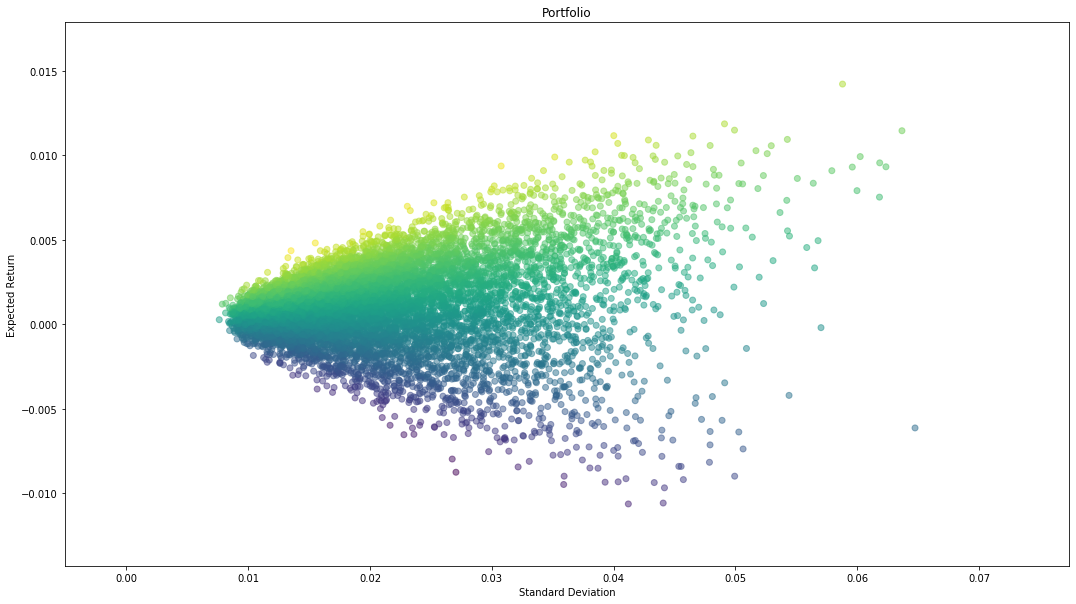

In [16]:
chartData(constraint1_ns,
            objective_ns,
            15,
            1,
            10000)

## 3.3 Solutions

### 3.3.1 Shorting Not Allowed, Quadratic Solution


In order to achieve minimum possible variance, the variance summation formula is tried to be minimized. 

$$ \frac{1}{2} \sum_{i,j=1}^{n}w_{i}w_{j}σ_{ij} $$ 

By providing equation below, which imposes the boundaries for the weights to the optimizer.

$$ (\sum_{i=1}^{n}w_{i}) - 1 = 0  $$

input set for the solution set is stated as sol.x and the variance for the optimal weigths, sol.fun.



In [17]:
b = (0.0,1.0)
variable_bounds = ( b,b,b,b,b,b,b,b,b,b,b,b,b,b,b )
con2 = {'type':'eq', 'fun':constraint2_ns} 
sol = minimize(objective_ns,
               initial_weigths,
               method="SLSQP",
               bounds=variable_bounds,
               constraints=con2
              )
sol

     fun: 0.0002503771798021417
     jac: array([ 2.29763071e-04,  2.51840858e-04,  2.60977955e-04,  2.41546924e-04,
        2.69668861e-04,  6.64111649e-04,  7.96747583e-04,  4.04639475e-04,
        2.12463667e-04,  3.54979707e-04,  5.75273953e-05,  4.50924355e-04,
        1.96380992e-04, -2.42750975e-05,  5.44682916e-06])
 message: 'Optimization terminated successfully.'
    nfev: 34
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.06254390e-01, 9.21828395e-02, 3.46944695e-18, 3.87954771e-02,
       1.38777878e-17, 2.25860602e-01, 2.47490576e-01, 1.44612682e-02,
       8.89819069e-02, 4.20518449e-02, 2.03651194e-02, 1.23555977e-01,
       3.46944695e-18, 0.00000000e+00, 1.04083409e-17])

In [18]:
print("Minimum Variance: ", sol.fun)
print("Expected daily return: %", 100*constraint1_ns(sol.x))
print("Expected weekly return: %", 100*5*constraint1_ns(sol.x))
print("Sum of weigths: ", np.sum( sol.x ) )
Weigths = pd.DataFrame( {"Value":sol.x} )
Weigths.index.rename("Weigth No", inplace=True)
print("Maximum weigth is of Weigth No: ",
      Weigths["Value"][Weigths["Value"] == max(Weigths.Value)].index[0],
      "and has a value of:",
      max(Weigths.Value) )
print("Minimum weigth is of Weigth No: ",
      Weigths["Value"][Weigths["Value"] == min(Weigths.Value)].index[0],
      "and has a value of:",
      min(Weigths.Value) )
Weigths.transpose()

Minimum Variance:  0.0002503771798021417
Expected daily return: % 0.3269496022499827
Expected weekly return: % 1.6347480112499138
Sum of weigths:  1.0000000000000002
Maximum weigth is of Weigth No:  6 and has a value of: 0.24749057557359616
Minimum weigth is of Weigth No:  13 and has a value of: 0.0


Weigth No,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Value,0.106254,0.092183,3.469447e-18,0.038795,1.387779e-17,0.225861,0.247491,0.014461,0.088982,0.042052,0.020365,0.123556,3.469447e-18,0.0,1.040834e-17


### 3.3.2 Shorting Allowed, Algebraic Solution

$$ \sum_{j=1}^{n}w_{j}σ{ij} - λṝ{i} - µ = 0 $$ 


In [19]:
initial_weigths = list(example_portfolios.loc["Weigths, Mean",:].values)
def objective_s( initial_weigths ):
    ms = 0
    for i in np.dot( covariance_matrix.values, initial_weigths ) - np.ones( len(initial_weigths) ):
        ms = ms + (i**2)/len(initial_weigths)
    return ms

def constraint2_s(initial_weigths):
    return (1-np.sum(initial_weigths))


In [20]:
b = (-9999999, 9999999)
variable_bounds = ( b,b,b,b,b,b,b,b,b,b,b,b,b,b,b )
con2 = {'type':'eq', 'fun':constraint2_ns} 
sol = minimize(objective_s,
               initial_weigths,
               method="TNC",
               bounds=variable_bounds,
              )
sol

     fun: 0.012650458951864806
     jac: array([ 4.75262191e-06,  5.50809398e-06,  1.92987987e-06,  5.50341023e-06,
        7.83227649e-06,  4.57966998e-08,  6.18099322e-06,  8.01112648e-06,
        4.58192512e-06,  2.31013125e-06,  5.06140269e-06, -5.02375919e-07,
        7.04453856e-06,  1.20563282e-07,  3.18495230e-07])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 113
     nit: 21
  status: 2
 success: True
       x: array([3088.49268455, 1166.6913973 , 1171.07581833, 1128.91926494,
       -188.26298518,  757.43115512, -905.33046391,  688.33541678,
       2109.38580363, -892.47568651, 2577.88028929,  996.31580326,
       -627.17091292, 8397.29920266, 2907.16597623])

In [21]:
# since vi = lambda*wi, vi's are scaled to (-1, 1)
solution_set = sol.x
scaler = MinMaxScaler(feature_range=(-1, 1))
solution_set = pd.DataFrame({
    "vi":list(solution_set)
})
solution_set = scaler.fit_transform(solution_set)

#then scaled again to obtain sum of 1
solution_set = solution_set/np.sum(solution_set)

print("Minimum variance: ", objective_ns(solution_set)[0])
print("Expected daily return: %", 100*constraint1_ns(solution_set.T)[0])
print("Expected weekly return: %", 5*100*constraint1_ns(solution_set.T)[0])
print("Sum of weigths: ", sum(solution_set))
solution_set.T

Minimum variance:  0.00021012878349041048
Expected daily return: % 0.0045028738483140025
Expected weekly return: % 0.022514369241570013
Sum of weigths:  [1.]


array([[ 0.01944436,  0.07627882,  0.07614916,  0.07739587,  0.11634961,
         0.08838209,  0.13755584,  0.0904255 ,  0.04840001,  0.13717568,
         0.03454497,  0.08131743,  0.12932967, -0.13755584,  0.02480683]])

## 4. One-fund theorem

### 4.1 Algebraic Model

$$ \sum_{i=1}^{n}σki  *  v1 = ṝ{k} - ṝ{f} $$ 

In [22]:
#risk free yearly to daily
r = 0.062/52/5
#Linear algebraic solution for Eq6.10 pg168
vi_matrix = np.linalg.inv(covariance_matrix.values).dot(example_portfolios.loc["Mean",:].values-r)

#scaling lambda*wi between -1,+1
scaler = MinMaxScaler(feature_range=(-1, 1))
vi_df = pd.DataFrame({
    "vi":list(vi_matrix)
})
vi_matrix = scaler.fit_transform(vi_df)

#scaling again so that the sum is 1
vi_matrix = vi_matrix / sum(vi_matrix)

print("Sum of weigths: ", sum(vi_matrix))
print("Risk free daily return rate: ", r)
print("Expected daily return of optimal portfolio for combination with risk free asset: %",100*constraint1_ns(vi_matrix)[0])
print("Expected weekly return of optimal portfolio for combination with risk free asset: %",5*100*constraint1_ns(vi_matrix)[0])
vi_matrix.T

Sum of weigths:  [1.]
Risk free daily return rate:  0.00023846153846153847
Expected daily return of optimal portfolio for combination with risk free asset: % 0.2621189139610029
Expected weekly return of optimal portfolio for combination with risk free asset: % 1.3105945698050143


array([[ 0.17357397,  0.13287388, -0.03066117,  0.0766822 ,  0.02521329,
         0.10528962,  0.09529548, -0.08504348,  0.15080407,  0.08058162,
         0.12475292,  0.12852718,  0.04089924,  0.15478516, -0.17357397]])

### 4.2 Expected Return

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


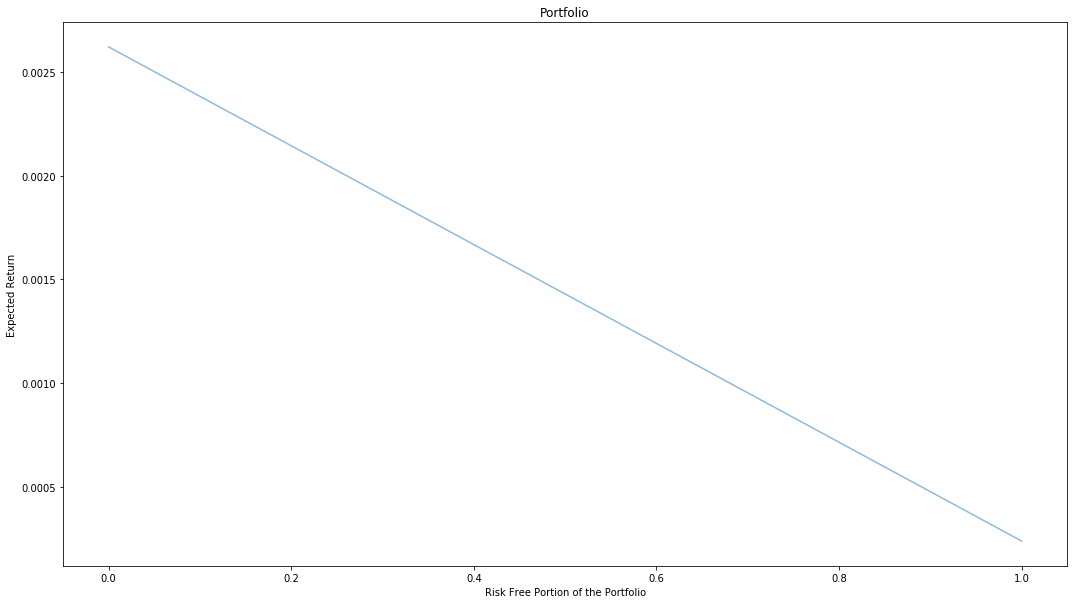

In [23]:
alpha=[] #risk free rate ratio of the portfolio
response=[]
prob=[] #Probability of appreciating more than the risk free rate
inf = 0.062 #inflation
for i in np.linspace(0.0,1.0,110):
    alpha.append(i)
    response.append( r*i + (1-i)*constraint1_ns(vi_matrix) )
    prob.append(st.norm.cdf( 1 -( i*r/((1-i)*objective_ns(vi_matrix)))))
    
plt.figure(figsize = (18,10))
plt.plot( alpha, response,
                alpha=0.5 )
plt.title("Portfolio")
plt.xlabel("Risk Free Portion of the Portfolio")
plt.ylabel("Expected Return")
plt.show()


### 4.3 Probability


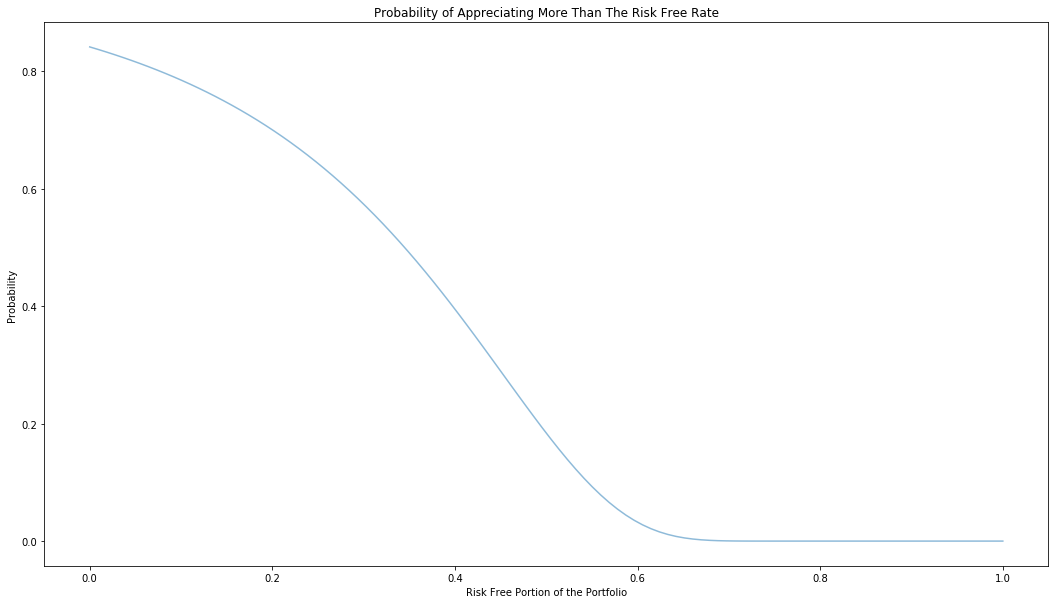

In [24]:
plt.figure(figsize = (18,10))
plt.plot( alpha, prob,
                alpha=0.5 )
plt.title("Probability of Appreciating More Than The Risk Free Rate")
plt.xlabel("Risk Free Portion of the Portfolio")
plt.ylabel("Probability")
plt.show()